In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean, median
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
import tensorflow.keras as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU, LSTM, Conv1D, Conv2D
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import csv
import random

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [2]:
def retrieve_data(varname, filename):
#     df = pd.read_csv(filename, index_col=0)
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

def create_classification_data(df, lookback, column):
    rows = []
    columns = ['Date', column] # Date and SP500_relative_change_perc_1 from t-0 are added first as target variables 
    
    # create column names based on original with the addition of t-i where i is lookback
    for i in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
        new_columns = df.columns.tolist() # starts at 1 to exclude 'Date' column
        for x in range(len(new_columns)):
            new_columns[x] = new_columns[x] + "_t-" + str(i)
        columns = columns + new_columns
    
    # create lookback data
    for i, row in enumerate(df.iterrows()):
        if i > lookback: # lookback cannot be determined for earlier rows
            new_row = [row[1]['Date'], row[1][column]]
#             new_row = [row[1][0], row[1][1]] # add target 'Date' and 'SP500_relative_change_perc_1 '
            for x in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
                add_row = df.iloc[i - x].tolist() # starts at 1 to exclude 'Date' column
                new_row = new_row + add_row
            rows.append(new_row)
    
    df2 = pd.DataFrame(rows)
    df2.columns = columns
                       
    for col in columns:
        if col[:4] == "Date" and col != "Date":
            df2 = df2.drop([col], axis=1)
    return df2

def create_train_val_test(df, year_val, year_test, perc_train=None):
    if perc_train == None:
        # assumes years_train < year_val < year_test
        df["Date"] = pd.to_datetime(df["Date"])
        
        val = df[df['Date'].dt.year == year_val]
        test = df[df['Date'].dt.year == year_test]
        train = df[df['Date'].dt.year < year_val]
    else:
        train = df.head(round(len(df) * perc_train))
        val = df.tail(len(df) - len(train))
        test = val.tail(round(0.5 * len(val)))
        val = df.head(len(val) - len(test))
    
    return train, val, test

def scale_data(x):
    standard_scaler = MinMaxScaler()
    x = x.drop(["Date"], axis=1)
    x_scaled = pd.DataFrame(standard_scaler.fit_transform(x), columns=x.columns)
    return x_scaled

In [3]:
lookback = 3
val_year = 2018
test_year = 2019

files = {
    # varname: filename
    "NASDAQ": "Dataset v3/NASDAQ_combined_data_20220422.csv"
}

column = 'NASDAQ_relative_change_perc_1'

for file in files:
    df = retrieve_data(file, files[file])
df = create_classification_data(df, lookback, column)

train, val, test = create_train_val_test(df, val_year, test_year)

In [4]:
def label_data(y):
    positives = []
    negatives = []
    y = list(y)
    for dev in y:
        if dev >= 0:
            positives.append(dev)
        else:
            negatives.append(dev)
    med_pos = median(positives)
    med_neg = median(negatives)
    
    labels = []
    for dev in y:
        if dev >= med_pos or dev <= med_neg:
            labels.append(1)
        else:
            labels.append(0)
    return labels

train['label'] = label_data(train[column])
val['label'] = label_data(val[column])
test['label'] = label_data(test[column])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [5]:
def random_baseline(y):
    counts = [0, 0]
    for i in y:
        
        if int(i) == 0:
            counts[0] = counts[0] + 1
        elif int(i) == 1:
            counts[1] = counts[1] + 1
    print(f"\tDistribution: {counts}")
    print(f"\tRandom baseline accuracy (majority class): {counts[np.argmax(np.asarray(counts))]/ len(y)}")
    
print("Random baseline training set")
random_baseline(train['label'])
print("Random baseline validation set")
random_baseline(val['label'])
print("Random baseline test set")
random_baseline(test['label'])

Random baseline training set
	Distribution: [1068, 1069]
	Random baseline accuracy (majority class): 0.5002339728591484
Random baseline validation set
	Distribution: [125, 126]
	Random baseline accuracy (majority class): 0.50199203187251
Random baseline test set
	Distribution: [126, 126]
	Random baseline accuracy (majority class): 0.5


In [6]:
train['pred'] = train['label'].copy()
train['pred'] = train['pred'].shift(1)
train = train[1:]

val['pred'] = val['label'].copy()
val['pred'] = val['pred'].shift(1)
val = val[1:]

test['pred'] = test['label'].copy()
test['pred'] = test['pred'].shift(1)
test = test[1:]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [7]:
def evaluate(y, y_pred):
    
    for i in range(len(y)):
        y[i] = int(y[i])
        y_pred[i] = int(y_pred[i])
    
    acc = accuracy(y, y_pred)
    print(f"\tAccuracy: {acc}")
    
    prec = precision(y, y_pred)
    print(f"\tPrecision: {prec}")
    
    rec = recall(y, y_pred)
    print(f"\tRecall: {rec}")
    
    f = f1(y, y_pred)
    print(f"\tF1-score: {f}")
    
print("Training set evaluation")
evaluate(train['label'].tolist(), train['pred'].tolist())
print("Validation set evaluation")
evaluate(val['label'].tolist(), val['pred'].tolist())
print("Test set evaluation")
evaluate(test['label'].tolist(), test['pred'].tolist())

Training set evaluation
	Accuracy: 0.5543071161048689
	Precision: 0.5543071161048689
	Recall: 0.5543071161048689
	F1-score: 0.5543071161048689
Validation set evaluation
	Accuracy: 0.54
	Precision: 0.5396825396825397
	Recall: 0.544
	F1-score: 0.5418326693227092
Test set evaluation
	Accuracy: 0.5298804780876494
	Precision: 0.528
	Recall: 0.528
	F1-score: 0.528


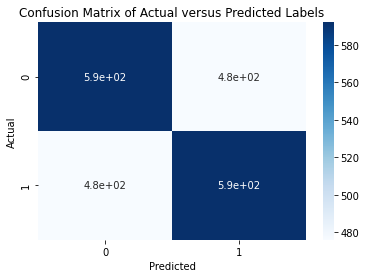

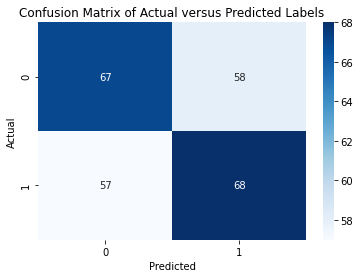

In [8]:
def confusion_matrix(y, y_pred):

    originals = []
    predictions = []

    for i in range(len(y_pred)):
        originals.append(int(y[i]))
        predictions.append(int(y_pred[i]))
        
    df = pd.DataFrame()
    df['Actual'] = originals
    df['Predicted'] = predictions
    
    conf_matrix = pd.crosstab(df['Actual'], df['Predicted'])
    sns.heatmap(conf_matrix, annot=True, cmap='Blues')
    plt.title("Confusion Matrix of Actual versus Predicted Labels")
    plt.show()
    
confusion_matrix(train['label'].tolist(), train['pred'].tolist())
confusion_matrix(val['label'].tolist(), val['pred'].tolist())

In [9]:
def retrieve_candles(filename, val_year, test_year):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    df.columns = ["Date", "Close", "Open", "High", "Low", "Vol.", "Change%"]
    df = df.sort_values('Date', ascending=True)
    
    candles_val = df[df['Date'].dt.year == val_year]
    candles_train = df[df['Date'].dt.year < val_year]
    candles_train = candles_train[candles_train['Date'] > datetime(2009,7,10)]
    
    candles_train = candles_train.replace(',','', regex=True)
    candles_val = candles_val.replace(',','', regex=True)

    return candles_train, candles_val

def plot_predictions_candles(x, y, df, dataset):
    # PREDICTIONS LIJKEN NOG NIET GOED UITGELIJND MET CANDLES???
    originals = []
    predictions = []
    y_pred = model.predict(x)
    for i in range(len(y_pred)):
        originals.append(np.argmax(y[i]))
        predictions.append(np.argmax(y_pred[i]))
    
    for i in range(len(originals)):
        if originals[i] == 0:
            originals[i] = -2
        elif originals[i] == 1:
            originals[i] = -1
        elif originals[i] == 2:
            originals[i] = 1
        elif originals[i] == 3:
            originals[i] = 2
        
        if predictions[i] == 0:
            predictions[i] = -2
        elif predictions[i] == 1:
            predictions[i] = -1
        elif predictions[i] == 2:
            predictions[i] = 1
        elif predictions[i] == 3:
            predictions[i] = 2

    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name="Price"))
    standard_factor = 0.5 * mean([float(df.iloc[0].tolist()[3]), float(df.iloc[0].tolist()[4])])
    
    green_legend = False
    orange_legend = False
    red_legend = False
    
    for i, row in enumerate(df.iterrows()):
        pred_date = row[1][0].to_pydatetime()
        pred_high = float(row[1][3])
        pred_low = float(row[1][4])
#         real_label = row[1][7]
#         pred_label = row[1][8]
        real_label = originals[i]
        pred_label = predictions[i]
        
        start_shape = pred_date - timedelta(days=0.1)
        end_shape = pred_date + timedelta(days=0.1)
        
        if pred_label == 1:
            extreme = pred_high + 0.1 * standard_factor
            standard = pred_high + 0.05 * standard_factor
        elif pred_label == 2:
            extreme = pred_high + 0.2 * standard_factor
            standard = pred_high + 0.05 * standard_factor
        elif pred_label == -1:
            extreme = pred_low - 0.1 * standard_factor
            standard = pred_low -  0.05 * standard_factor
        elif pred_label == -2:
            extreme = pred_low - 0.2 * standard_factor
            standard = pred_low - 0.05 * standard_factor
            
        if real_label == pred_label:
            color = "green"
        elif np.sign(real_label) == np.sign(pred_label):
            color = "orange"
        else:
            color = "red"
        
        if real_label == pred_label and not green_legend:
            green_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Correct Direction / Correct Magnitude", mode="lines", line=dict(color=color)))
        elif np.sign(real_label) == np.sign(pred_label) and not orange_legend:
            orange_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Correct Direction / Inorrect Magnitude", mode="lines", line=dict(color=color)))
        elif np.sign(real_label) != np.sign(pred_label) and not red_legend:
            red_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Incorrect Direction", mode="lines", line=dict(color=color)))
        else:
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", showlegend=False, mode="lines", line=dict(color=color)))
    
    title = f"Visualization of {dataset} Predictions"
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    layout = dict(title=title, height=800, width=1500)
    fig.update_layout(layout)
#     config = dict({'scrollZoom': True})
#     fig.show(config=config)
    fig.show()

filename = "Dataset v3/Indices/S&P 500 Historical Data.csv"
candles_train, candles_val = retrieve_candles(filename, val_year, test_year) 
plot_predictions_candles(x_train, y_train, candles_train, "Training")
plot_predictions_candles(x_val, y_val, candles_val, "Validation")

NameError: name 'x_train' is not defined